# Reprogramming Imagenet to Caltech101


In [3]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import os

Using TensorFlow backend.


### Getting a dataset

The first step is going to be to load our data. As our example, we will be using the dataset [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains around 9000 labeled images belonging to 101 object categories. However, we will exclude 5 of the categories which have the most images. This is in order to keep the class distribution fairly balanced (around 50-100) and constrained to a smaller number of images, around 6000. 

To obtain this dataset, you can either run the download script `download.sh` in the `data` folder, or the following commands:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz

If you wish to use your own dataset, it should be aranged in the same fashion to `101_ObjectCategories` with all of the images organized into subfolders, one for each class. In this case, the following cell should load your custom dataset correctly by just replacing `root` with your folder. If you have an alternate structure, you just need to make sure that you load the list `data` where every element is a dict where `x` is the data (a 1-d numpy array) and `y` is the label (an integer). Use the helper function `get_image(path)` to load the image correctly into the array, and note also that the images are being resized to 224x224. This is necessary because the input to VGG16 is a 224x224 RGB image. You do not need to resize them on your hard drive, as that is being done in the code below.

If you have `101_ObjectCategories` in your data folder, the following cell should load all the data.

In [0]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls


######################################################################## 100.0%
101_ObjectCategories  sample_data


In [5]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/schooner', '101_ObjectCategories/elephant', '101_ObjectCategories/crocodile', '101_ObjectCategories/pigeon', '101_ObjectCategories/kangaroo', '101_ObjectCategories/pagoda', '101_ObjectCategories/rhino', '101_ObjectCategories/euphonium', '101_ObjectCategories/brain', '101_ObjectCategories/llama', '101_ObjectCategories/sunflower', '101_ObjectCategories/starfish', '101_ObjectCategories/sea_horse', '101_ObjectCategories/crocodile_head', '101_ObjectCategories/garfield', '101_ObjectCategories/binocular', '101_ObjectCategories/dollar_bill', '101_ObjectCategories/panda', '101_ObjectCategories/mayfly', '101_ObjectCategories/hedgehog', '101_ObjectCategories/cannon', '101_ObjectCategories/menorah', '101_ObjectCategories/platypus', '101_ObjectCategories/revolver', '101_ObjectCategories/pizza', '101_ObjectCategories/mandolin', '101_ObjectCategories/rooster', '101_ObjectCategories/barrel', '101_ObjectCategories/camera', '101_ObjectCategories/watch', '101_ObjectCategories/ant',

This function is useful for pre-processing the data into an image and input vector.

In [0]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [0]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomize the data order.

In [0]:
random.shuffle(data)

create training / validation / test split (70%, 15%, 15%)

In [0]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [0]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [11]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Let's get a summary of what we have.

In [12]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


If everything worked properly, you should have loaded a bunch of images, and split them into three sets: `train`, `val`, and `test`. The shape of the training data should be (`n`, 224, 224, 3) where `n` is the size of your training set, and the labels should be (`n`, `c`) where `c` is the number of classes (97 in the case of `101_ObjectCategories`. 

Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

Let's quickly look at a few sample images from our dataset.

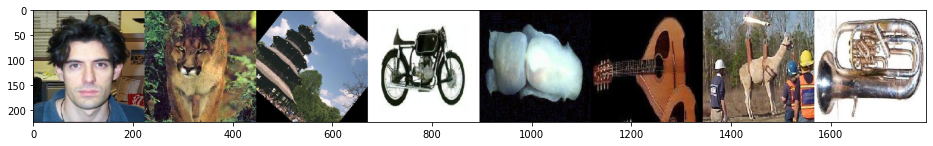

In [13]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [14]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


Input dimensions:  (224, 224, 3)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (Non

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later. 

In [15]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4346 samples, validate on 931 samples
Epoch 1/10





4346/4346 [==============================] - 20s 4ms/step - loss: 4.5185 - acc: 0.0380 - val_loss: 4.4619 - val_acc: 0.0698
Epoch 2/10
4346/4346 [==============================] - 4s 954us/step - loss: 4.3330 - acc: 0.0743 - val_loss: 4.1414 - val_acc: 0.1386
Epoch 3/10
4346/4346 [==============================] - 4s 961us/step - loss: 3.9742 - acc: 0.1475 - val_loss: 3.7927 - val_acc: 0.2127
Epoch 4/10
4346/4346 [==============================] - 4s 962us/step - loss: 3.5585 - acc: 0.2062 - val_loss: 3.4066 - val_acc: 0.2589
Epoch 5/10
4346/4346 [==============================] - 4s 962us/step - loss: 3.1776 - acc: 0.2729 - val_loss: 3.1693 - val_acc: 0.3018
Epoch 6/10
4346/4346 [==============================] - 4s 964us/step - loss: 2.8132 - acc: 0.3456 - val_loss: 3.0357 - val_acc: 0.3265
Epoch 7/10
4346/4346 [============

Let's plot the validation loss and validation accuracy over time.

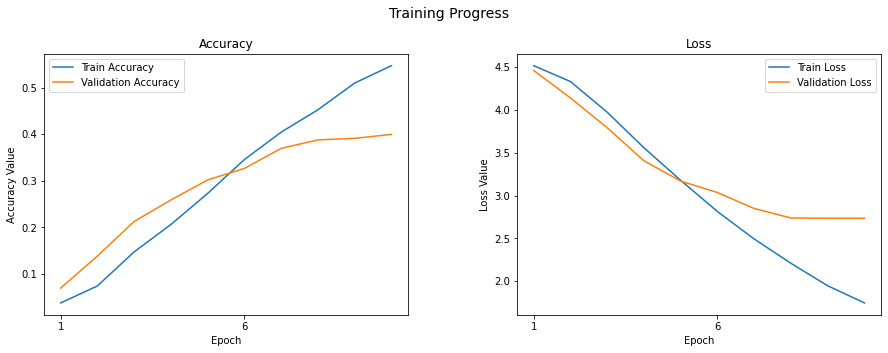

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Training Progress', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,10+1))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs[::5])
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs[::5])
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.7058542061261353
Test accuracy: 0.3894849785407725


In [21]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', loss)
print('Train accuracy:', accuracy)

Train loss: 0.8445211377113139
Train accuracy: 0.8515876666829162


## Next, Reprogramming


In [22]:
net = keras.applications.ResNet152V2(weights='imagenet', include_top=True)
net.summary()


242753536/242745792 [==============================] - 3s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are not just 97, but 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 97 neurons in the case of the 101_ObjectCategories dataset. 

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [0]:
# make a reference to VGG's input layer
inp = net.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(net.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [24]:
inp

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset. 

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of CalTech-101, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [25]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 97-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [26]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))


Train on 4346 samples, validate on 931 samples
Epoch 1/10
4346/4346 [==============================] - 31s 7ms/step - loss: 2.6729 - acc: 0.4563 - val_loss: 0.8080 - val_acc: 0.7959
Epoch 2/10
4346/4346 [==============================] - 22s 5ms/step - loss: 0.6207 - acc: 0.9008 - val_loss: 0.4831 - val_acc: 0.8582
Epoch 3/10
4346/4346 [==============================] - 22s 5ms/step - loss: 0.3061 - acc: 0.9567 - val_loss: 0.4151 - val_acc: 0.8786
Epoch 4/10
4346/4346 [==============================] - 22s 5ms/step - loss: 0.2019 - acc: 0.9765 - val_loss: 0.3942 - val_acc: 0.8872
Epoch 5/10
4346/4346 [==============================] - 22s 5ms/step - loss: 0.1388 - acc: 0.9887 - val_loss: 0.3925 - val_acc: 0.8861
Epoch 6/10
4346/4346 [==============================] - 22s 5ms/step - loss: 0.1034 - acc: 0.9929 - val_loss: 0.3896 - val_acc: 0.8904
Epoch 7/10
4346/4346 [==============================] - 22s 5ms/step - loss: 0.0806 - acc: 0.9959 - val_loss: 0.3802 - val_acc: 0.8980
Epoch 8/

In [27]:
# Check the trainable status of the individual layers
for layer in model_new.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7bd5d86908> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7bd4ac0470> False
<keras.layers.convolutional.Conv2D object at 0x7f7bd4ac0f28> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7bd4babef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7bd4bab9e8> False
<keras.layers.normalization.BatchNormalization object at 0x7f7bd4946e80> False
<keras.layers.core.Activation object at 0x7f7bd49e9d68> False
<keras.layers.convolutional.Conv2D object at 0x7f7bd48d87f0> False
<keras.layers.normalization.BatchNormalization object at 0x7f7bd48e8198> False
<keras.layers.core.Activation object at 0x7f7bd48e8fd0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7bd4870ac8> False
<keras.layers.convolutional.Conv2D object at 0x7f7bd487fcf8> False
<keras.layers.normalization.BatchNormalization object at 0x7f7bd4831978> False
<keras.layers.core.Activation object at 0x7f7bd4831d68> False
<keras.layers.conv

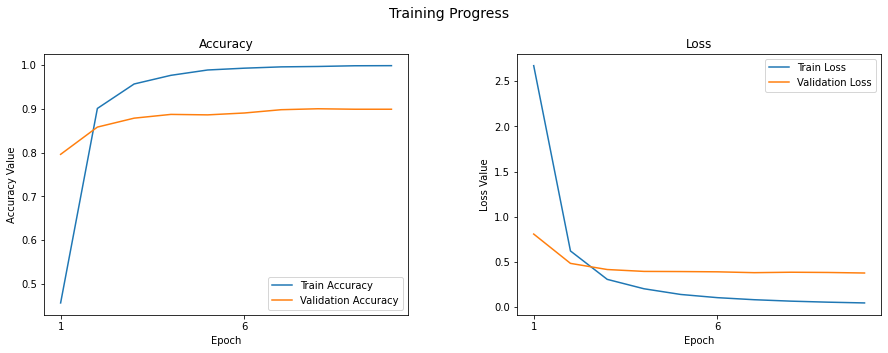

In [30]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Training Progress', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,10+1))
ax1.plot(epochs, history2.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history2.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs[::5])
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history2.history['loss'], label='Train Loss')
ax2.plot(epochs, history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs[::5])
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
train_loss, train_accuracy = model_new.evaluate(x_train, y_train, verbose=0)

#print('Train loss:', train_loss)
print('Train accuracy:', train_accuracy)

Train accuracy: 0.9811320754716981


In [32]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

#print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test accuracy: 0.8851931330472103


To predict a new image, simply run the following code to get the probabilities for each class.